In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torch.nn import Module, ModuleList, Sequential
import torch_geometric
from torch_geometric.nn import DenseGCNConv, DenseGraphConv, GCNConv, GATConv,SAGEConv
from torch.utils.data import DataLoader
import torch_scatter
from torch_geometric.data import Data

import numpy as np
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Distances Calculation

In [2]:
#Euclidean distance
def pairwise_euclidean_distances(x, dim=-1):
    dist = torch.cdist(x,x)**2
    return dist, x

#Cosine distance
def pairwise_cosine_distances(x, dim=-1):
    x_norm = torch.nn.functional.normalize(x, p=2, dim=dim)
    similarity = torch.matmul(x_norm, x_norm.t())
    distance = 1 - similarity
    return distance, x

#Manhattan distance
def pairwise_manhattan_distances(x, dim=-1):
    dist = torch.cdist(x, x, p=1)
    return dist, x

# #Poincarè disk distance r=1 (Hyperbolic)
def pairwise_poincare_distances(x, dim=-1):
    x_norm = (x**2).sum(dim,keepdim=True)
    x_norm = (x_norm.sqrt()-1).relu() + 1 
    x = x/(x_norm*(1+1e-2))
    x_norm = (x**2).sum(dim,keepdim=True)
    
    pq = torch.cdist(x,x)**2
    dist = torch.arccosh(1e-6+1+2*pq/((1-x_norm)*(1-x_norm.transpose(-1,-2))))**2
    return dist, x

## Layers

#### Edge Generation

In [3]:
class EdgeSamplingGumbel(nn.Module):
    def __init__(self, k=5, distance='hyperbolic'):
        super(EdgeSamplingGumbel, self).__init__()

        self.k = k
        self.eps=1e-8
        
        if distance == 'euclidean':
            self.distance = pairwise_euclidean_distances
            self.temperature = nn.Parameter(torch.tensor(4).float(), requires_grad = True)
        if distance == 'cosine':
            self.distance = pairwise_cosine_distances
            self.temperature = nn.Parameter(torch.tensor(4.).float(), requires_grad = True)
        if distance == 'manhattan':
            self.distance = pairwise_manhattan_distances
            self.temperature = nn.Parameter(torch.tensor(1.).float(), requires_grad = True)
        else:
            self.distance = pairwise_poincare_distances
            self.temperature = nn.Parameter(torch.tensor(5.).float(), requires_grad = True)
        
    def forward(self, x): 
        
        if self.training:
            
            dist, _x = self.distance(x)
           
            edge_index, edge_weights = self.gumbel_top_k(dist) 
                
        else:
            with torch.no_grad():
                dist, _x = self.distance(x)

                edge_index, edge_weights = self.gumbel_top_k(dist)

        return x, edge_index, edge_weights
    

    def gumbel_top_k(self, distance_mx):
        num_nodes = distance_mx.shape[0]
        distance_mx = distance_mx * torch.exp(torch.clamp(self.temperature,-5,5))
        #distance_mx = torch.exp(-self.temperature * distance_mx) + self.eps
        
        q = torch.rand_like(distance_mx)
        lq = (distance_mx-torch.log(-torch.log(q)))
        #lq=torch.nn.functional.gumbel_softmax(distance_mx)
        
        logprobs, indices = torch.topk(-lq,self.k)  
    
        rows = torch.arange(num_nodes).view(num_nodes,1).to(distance_mx.device).repeat(1,self.k)
        edges = torch.stack((indices.view(-1),rows.view(-1)),-2)
        
        return edges, logprobs.view(-1)

#### Some util layers

In [4]:
# Flatten layer
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)
    
# Reshape layer    
class Reshape(nn.Module):
    def __init__(self, outer_shape):
        super(Reshape, self).__init__()
        self.outer_shape = outer_shape
    def forward(self, x):
        return x.view(x.size(0), *self.outer_shape)

#### Sampling layers for VAE and VGAE

In [5]:
# Sample from the Gumbel-Softmax distribution and optionally discretize.
class GumbelSoftmax(nn.Module):

    def __init__(self, f_dim, c_dim):
        super(GumbelSoftmax, self).__init__()
        self.logits = nn.Linear(f_dim, c_dim)
        self.f_dim = f_dim
        self.c_dim = c_dim
     
    def sample_gumbel(self, shape, is_cuda=False, eps=1e-20):
        U = torch.rand(shape)
        if is_cuda:
            U = U.cuda()
        return -torch.log(-torch.log(U + eps) + eps)

    def gumbel_softmax_sample(self, logits, temperature):
        y = logits + self.sample_gumbel(logits.size(), logits.is_cuda)
        return F.softmax(y / temperature, dim=-1)

    def gumbel_softmax(self, logits, temperature, hard=False):
        """
        ST-gumple-softmax
        input: [*, n_class]
        return: flatten --> [*, n_class] an one-hot vector
        """
        #categorical_dim = 10
        y = self.gumbel_softmax_sample(logits, temperature)

        if not hard:
            return y

        shape = y.size()
        _, ind = y.max(dim=-1)
        y_hard = torch.zeros_like(y).view(-1, shape[-1])
        y_hard.scatter_(1, ind.view(-1, 1), 1)
        y_hard = y_hard.view(*shape)
        # Set gradients w.r.t. y_hard gradients w.r.t. y
        y_hard = (y_hard - y).detach() + y
        return y_hard 
  
    def forward(self, x, temperature=1.0, hard=False):
        logits = self.logits(x).view(-1, self.c_dim)
        prob = F.softmax(logits, dim=-1)
        y = self.gumbel_softmax(logits, temperature, hard)
        return logits, prob, y

In [6]:
# Sample from a Gaussian distribution
class Gaussian(nn.Module):
    def __init__(self, in_dim, z_dim):
        super(Gaussian, self).__init__()
        self.mu = nn.Linear(in_dim, z_dim)
        self.var = nn.Linear(in_dim, z_dim)

    def reparameterize(self, mu, var):
        std = torch.sqrt(var + 1e-10)
        noise = torch.randn_like(std)
        z = mu + noise * std
        return z      

    def forward(self, x):
        mu = self.mu(x)
        var = F.softplus(self.var(x))
        z = self.reparameterize(mu, var)
        return mu, var, z 

####  GM-VAE 

In [7]:
# Inference Network
class InferenceNet(nn.Module):
    def __init__(self, x_dim, z_dim, y_dim, h_dim=256):
        super(InferenceNet, self).__init__()

        # q(y|x)
        self.inference_qyx = torch.nn.ModuleList([
            nn.Linear(x_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, h_dim),
            nn.ReLU(),
            GumbelSoftmax(h_dim, y_dim)
         ])

        # q(z|y,x)
        self.inference_qzyx = torch.nn.ModuleList([
            nn.Linear(x_dim + y_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, h_dim),
            nn.ReLU(),
            Gaussian(h_dim, z_dim)
         ])

      # q(y|x)
    def qyx(self, x, temperature, hard):
        num_layers = len(self.inference_qyx)
        for i, layer in enumerate(self.inference_qyx):
            if i == num_layers - 1:
                #last layer is gumbel softmax
                x = layer(x, temperature, hard)
            else:
                x = layer(x)
        return x

       # q(z|x,y)
    def qzxy(self, x, y):
        concat = torch.cat((x, y), dim=1)  
        for layer in self.inference_qzyx:
            concat = layer(concat)
        return concat
  
    def forward(self, x, temperature=1.0, hard=0):
        #x = Flatten(x)

        # q(y|x)
        logits, prob, y = self.qyx(x, temperature, hard)
    
        # q(z|x,y)
        mu, var, z = self.qzxy(x, y)

        output = {'mean': mu, 'var': var, 'gaussian': z, 
                  'logits': logits, 'prob_cat': prob, 'categorical': y}
        return output

In [8]:
# Generative Network
class GenerativeNet(nn.Module):
    def __init__(self, x_dim, z_dim, y_dim, h_dim=256):
        super(GenerativeNet, self).__init__()

        # p(z|y)
        self.y_mu = nn.Linear(y_dim, z_dim)
        self.y_var = nn.Linear(y_dim, z_dim)
 
        # p(x|z)
        self.generative_pxz = torch.nn.ModuleList([
            nn.Linear(z_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, x_dim),
            torch.nn.ReLU()
        ])

      # p(z|y)
    def pzy(self, y):
        y_mu = self.y_mu(y)
        y_var = F.softplus(self.y_var(y))
        return y_mu, y_var
  
      # p(x|z)
    def pxz(self, z):
        for layer in self.generative_pxz:
            z = layer(z)
        return z

    def forward(self, z, y):
        # p(z|y)
        y_mu, y_var = self.pzy(y)
    
        # p(x|z)
        x_rec = self.pxz(z)

        output = {'y_mean': y_mu, 'y_var': y_var, 'x_rec': x_rec}
        return output

In [9]:
# GMVAE Network
class GMVAENet(nn.Module):
    def __init__(self, x, z_dim=64, y_dim=4, h_dim_in=128, h_dim_ge=128):
        super(GMVAENet, self).__init__()
        
        x_dim=x.shape[-1]

        self.inference = InferenceNet(x_dim, z_dim, y_dim, h_dim=h_dim_in)
        self.generative = GenerativeNet(x_dim, z_dim, y_dim, h_dim=h_dim_ge)

        # weight initialization
        for m in self.modules():
            if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                torch.nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias, 0) 

    def forward(self, x, temperature=1.0, hard=0):
        x = x.view(x.size(0), -1)
        out_inf = self.inference(x, temperature, hard)
        z, y = out_inf['gaussian'], out_inf['categorical']
        out_gen = self.generative(z, y)
    
        # merge output
        output = out_inf
        for key, value in out_gen.items():
            output[key] = value
        return output

#### Simple Autoencoder

In [10]:
'''
class MLP(nn.Module): 
    def __init__(self,x,projection_dim=32,final_activation=False, dropout=0.2):
        super(MLP, self).__init__()
        self.x=x
        #self.x = torch.tensor(self.x, dtype=torch.float32)
        self.projection_dim=projection_dim
        layers_size=[self.x.shape[-1],projection_dim,self.x.shape[-1]]
        layers = []
        #layers.append(LeftTruncatedGaussianMixtureLayer(self.x.shape[-1],projection_dim))
        for li in range(1,len(layers_size)):
            if dropout>0:
                layers.append(nn.Dropout(dropout))
            layers.append(nn.Linear(layers_size[li-1],layers_size[li]))
            if li==len(layers_size)-1 and not final_activation:
                continue
            layers.append(nn.LeakyReLU(0.1))
            
            
        self.MLP = nn.Sequential(*layers)
        
    def forward(self, e=None):
        x_imp=self.x
        x_imp = self.MLP(x_imp)
        return x_imp
'''
class MLP(nn.Module): 
    def __init__(self, x, projection_dim=32, final_activation=False, dropout=0.2):
        super(MLP, self).__init__()
        self.x = x
        self.projection_dim = projection_dim
        layers_size = [self.x.shape[-1], projection_dim, self.x.shape[-1]]
        layers = []

        for li in range(1, len(layers_size)):
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            layers.append(nn.Linear(layers_size[li-1], layers_size[li]))
            if li == len(layers_size) - 1 and not final_activation:
                continue
            layers.append(nn.LeakyReLU(0.1))
            
        self.MLP = nn.Sequential(*layers)
        self.bottleneck_output = None
        
    def forward(self, e=None):
        x_imp = self.x
        self.bottleneck_output = self.MLP[:3](x_imp)  # Assuming the bottleneck layer is the middle linear layer
        x_imp = self.MLP(x_imp)
        return x_imp,self.bottleneck_output

#### GM-VGAE

In [11]:
# Inference Network
class InferenceNetGCN(nn.Module):
    def __init__(self, x_dim, z_dim, y_dim, h_dim=128):
        super(InferenceNetGCN, self).__init__()

        # q(y|x)
        self.inference_qyx = torch.nn.ModuleList([
            GCNConv(x_dim, h_dim),
            nn.ReLU(),
            GCNConv(h_dim, h_dim),
            nn.ReLU(),
            GumbelSoftmax(h_dim, y_dim)
         ])

        # q(z|y,x)
        self.inference_qzyx = torch.nn.ModuleList([
            GCNConv(x_dim + y_dim, h_dim),
            nn.ReLU(),
            GCNConv(h_dim, h_dim),
            nn.ReLU(),
            Gaussian(h_dim, z_dim)
         ])
    
     # q(y|x)
    def qyx(self, x, edge_index, temperature, hard):
        for layer in self.inference_qyx:
            if isinstance(layer, GumbelSoftmax):
                x = layer(x, temperature, hard)
            elif isinstance(layer, GCNConv):
                x = layer(x, edge_index)
            else:
                x = layer(x)
        return x

     # q(z|x,y)
    def qzxy(self, x, y, edge_index):
        concat = torch.cat((x, y), dim=1)
        for layer in self.inference_qzyx:
            if isinstance(layer, Gaussian):
                concat = layer(concat)
            elif isinstance(layer, GCNConv):
                concat = layer(concat, edge_index)
            else:
                concat = layer(concat)
        return concat

    # Modify the forward function to take in edge_index as well
    def forward(self, x, edge_index, temperature=1.0, hard=0):
        x = x.view(x.size(0), -1)
        # q(y|x)
        logits, prob, y = self.qyx(x, edge_index, temperature, hard)
    
        # q(z|x,y)
        mu, var, z = self.qzxy(x, y, edge_index)

        output = {'mean': mu, 'var': var, 'gaussian': z, 
                  'logits': logits, 'prob_cat': prob, 'categorical': y}
        return output

In [12]:
# Generative Network
class GenerativeNetGCN(nn.Module):
    def __init__(self, x_dim, z_dim, y_dim, h_dim=128):
        super(GenerativeNetGCN, self).__init__()

        # p(z|y)
        self.y_mu = GCNConv(y_dim, z_dim)
        self.y_var = GCNConv(y_dim, z_dim)
 
        # p(x|z)
        self.generative_pxz = torch.nn.ModuleList([
            GCNConv(z_dim, h_dim),
            nn.ReLU(),
            GCNConv(h_dim, h_dim),
            nn.ReLU(),
            GCNConv(h_dim, x_dim),
            torch.nn.Sigmoid()
        ])
        
      # p(z|y)
    def pzy(self, y, edge_index):
        y_mu = self.y_mu(y, edge_index)
        y_var = F.softplus(self.y_var(y, edge_index))
        return y_mu, y_var
  
     # p(x|z)
    def pxz(self, z, edge_index):
        for layer in self.generative_pxz:
            if isinstance(layer, GCNConv):
                z = layer(z, edge_index)
            else:
                z = layer(z)
        return z

    # Modify the forward function to take in edge_index as well
    def forward(self, z, y, edge_index):
        # p(z|y)
        y_mu, y_var = self.pzy(y, edge_index)
    
        # p(x|z)
        x_rec = self.pxz(z, edge_index)

        output = {'y_mean': y_mu, 'y_var': y_var, 'x_rec': x_rec}
        return output

In [13]:
# GMVGAE Network
class GMVAENetGCN(nn.Module):
    def __init__(self, x, z_dim=64, y_dim=4, h_dim_in=128, h_dim_ge=128):
        super(GMVAENetGCN, self).__init__()

        self.inference = InferenceNetGCN(x.shape[-1], z_dim, y_dim, h_dim=h_dim_in)
        self.generative = GenerativeNetGCN(x.shape[-1], z_dim, y_dim, h_dim=h_dim_ge)

        # weight initialization
        for m in self.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias, 0) 

    def forward(self, x, edge_index, size_factors, temperature=1.0, hard=0):
        x = x.view(x.size(0), -1)
        out_inf = self.inference(x, edge_index, temperature, hard)
        z, y = out_inf['gaussian'], out_inf['categorical']
        out_gen = self.generative(z, y, edge_index)
        out_gen['x_rec'] = out_gen['x_rec'] * size_factors
    
        # merge output
        output = out_inf
        for key, value in out_gen.items():
            output[key] = value
        return output

#### Simple Graph Autoencoder

In [14]:
class GAE(torch.nn.Module):
    #def __init__(self,input_dim=None,hidden_dim=64,impute_dim=None):
    def __init__(self,x):
        super(GAE, self).__init__()
        #self.num_features=x.shape[-1]
        self.conv1 = GCNConv(x.shape[-1], int(x.shape[-1]/64))
        self.encode_ln = torch.nn.LayerNorm(int(x.shape[-1]/64))
        self.conv2 = GCNConv(int(x.shape[-1]/64), x.shape[-1])
        
        #self.conv1 = GCNConv(input_dim, hidden_dim)
        #self.conv2 = GCNConv(hidden_dim, impute_dim)

    def forward(self, x, edge_index,size_factors):
        x = F.relu(self.encode_ln(self.conv1(x, edge_index)))
        x = F.dropout(x,p=0.0, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x=x*size_factors
        return x

## Imputation Model

In [15]:
class IntegratedModel(nn.Module):
    def __init__(self, x, size_factors, project='AE', imputation='GAE', k=5, distance='euclidean', z_dim=128, y_dim=4, 
                 h_dim_in=128, h_dim_ge=128, dropout=0.0, use_raw=True):
        super(IntegratedModel, self).__init__()
        self.mlp = MLP(x, projection_dim=z_dim, dropout=dropout)
        self.gmvae=GMVAENet(x,z_dim=z_dim,y_dim=y_dim, h_dim_in=h_dim_in, h_dim_ge=h_dim_ge)
        self.edgeSamplingGumbel = EdgeSamplingGumbel(k=k, distance=distance)
        self.gae = GAE(x)
        self.gmvgae = GMVAENetGCN(x, z_dim, y_dim)
        self.size_factors=size_factors
        self.project = project
        self.imputation = imputation
        self.use_raw=use_raw

    def forward(self,x):
        
        if self.project == 'AE':
            # Classic autoencoder
            _output = []
            x_imp,bottleneck_output = self.mlp(x)
        else:
            # Guassian mixer variational autoencoder
            _output = self.gmvae(x)
            x_imp = _output['x_rec']
            bottleneck_output = _output['gaussian']
        
        x_, edge_index, edge_weights=self.edgeSamplingGumbel(bottleneck_output)
        
        if self.imputation == 'GAE':
            if self.use_raw:
               # GraphAutoencoder
                output = self.gae(x, edge_index, self.size_factors)
            else:
                output = self.gae(x_imp, edge_index, self.size_factors)
                 
        else:
            if self.use_raw:
                # GM-VGAE  
                output=self.gmvgae(x, edge_index, self.size_factors)
            else:
                output=self.gmvgae(x_imp, edge_index, self.size_factors)

        return _output,x_imp,output

## Loss Functions

In [16]:
class LossFunctions:
    eps = 1e-8

    def mean_squared_error(self, real, predictions):
        """Mean Squared Error between the true and predicted outputs
           loss = (1/n)*Σ(real - predicted)^2

           Args:
           real: (array) corresponding array containing the true labels
           predictions: (array) corresponding array containing the predicted labels
 
           Returns:
           output: (array/float) depending on average parameters the result will be the mean
                                of all the sample losses or an array with the losses per sample
         """
        loss = (real - predictions).pow(2)
        return loss.sum(-1).mean()


    def reconstruction_loss(self, real, predicted, rec_type='mse' ):
        """Reconstruction loss between the true and predicted outputs
           mse = (1/n)*Σ(real - predicted)^2
           bce = (1/n) * -Σ(real*log(predicted) + (1 - real)*log(1 - predicted))

           Args:
           real: (array) corresponding array containing the true labels
           predictions: (array) corresponding array containing the predicted labels
 
           Returns:
           output: (array/float) depending on average parameters the result will be the mean
                                of all the sample losses or an array with the losses per sample
        """
        if rec_type == 'mse':
            loss = (real - predicted).pow(2)
        elif rec_type == 'bce':
            loss = F.binary_cross_entropy(predicted, real, reduction='none')
        else:
            raise "invalid loss function... try bce or mse..."
        return loss.sum(-1).mean()


    def log_normal(self, x, mu, var):
        """Logarithm of normal distribution with mean=mu and variance=var
           log(x|μ, σ^2) = loss = -0.5 * Σ log(2π) + log(σ^2) + ((x - μ)/σ)^2

           Args:
           x: (array) corresponding array containing the input
           mu: (array) corresponding array containing the mean 
           var: (array) corresponding array containing the variance

           Returns:
           output: (array/float) depending on average parameters the result will be the mean
                                of all the sample losses or an array with the losses per sample
         """
        if self.eps > 0.0:
            var = var + self.eps
        return -0.5 * torch.sum(
            np.log(2.0 * np.pi) + torch.log(var) + torch.pow(x - mu, 2) / var, dim=-1)


    def gaussian_loss(self, z, z_mu, z_var, z_mu_prior, z_var_prior):
        """Variational loss when using labeled data without considering reconstruction loss
           loss = log q(z|x,y) - log p(z) - log p(y)

           Args:
           z: (array) array containing the gaussian latent variable
           z_mu: (array) array containing the mean of the inference model
           z_var: (array) array containing the variance of the inference model
           z_mu_prior: (array) array containing the prior mean of the generative model
           z_var_prior: (array) array containing the prior variance of the generative mode
         
           Returns:
           output: (array/float) depending on average parameters the result will be the mean
                                of all the sample losses or an array with the losses per sample
        """
        loss = self.log_normal(z, z_mu, z_var) - self.log_normal(z, z_mu_prior, z_var_prior)
        return loss.mean()


    def entropy(self, logits, targets):
        """Entropy loss
           loss = (1/n) * -Σ targets*log(predicted)

           Args:
           logits: (array) corresponding array containing the logits of the categorical variable
           real: (array) corresponding array containing the true labels
 
           Returns:
           output: (array/float) depending on average parameters the result will be the mean
                                of all the sample losses or an array with the losses per sample
        """
        log_q = F.log_softmax(logits, dim=-1)
        return -torch.mean(torch.sum(targets * log_q, dim=-1))

def sparse_mse_loss(preds, labels, sparsity_weight = 0):
    mse_loss = F.mse_loss(preds, labels)
    sparsity_loss = torch.mean(torch.abs(preds))  # 稀疏惩罚项
    total_loss = mse_loss + sparsity_weight * sparsity_loss
    return total_loss

## Utils

In [17]:
import numpy as np
import scanpy as sc
import scipy.sparse as sp

from sklearn.decomposition import PCA
from sklearn.neighbors import kneighbors_graph

In [18]:
def normalize(adata, filter_min_counts=True, size_factors=True, normalize_input=True, logtrans_input=True):
    if filter_min_counts:
        sc.pp.filter_genes(adata, min_counts=1)
        sc.pp.filter_cells(adata, min_counts=1)

    if size_factors:
        sc.pp.normalize_per_cell(adata)
        adata.obs['size_factors'] = adata.obs.n_counts / np.median(adata.obs.n_counts)
    else:
        adata.obs['size_factors'] = 1.0

    if logtrans_input:
        sc.pp.log1p(adata)

    if normalize_input:
        sc.pp.scale(adata)

    return adata

In [19]:
def train_val_split(adata, seed, train_size=0.8, val_size=0.1, test_size=0.1):
    assert train_size + val_size + test_size == 1

    adata = adata.copy()
    np.random.seed(seed)

    cell_nums = adata.n_obs
    test_val = np.random.choice(cell_nums, int(cell_nums * (val_size + test_size)), replace=False)
    idx_train = [i for i in list(range(cell_nums)) if i not in test_val]
    idx_test = np.random.choice(test_val, int(len(test_val) * (test_size / (val_size + test_size))), replace=False)
    idx_val = [i for i in test_val if i not in idx_test]

    tmp = np.zeros(cell_nums, dtype=bool)
    tmp[idx_train] = True
    adata.obs['idx_train'] = tmp
    tmp = np.zeros(cell_nums, dtype=bool)
    tmp[idx_val] = True
    adata.obs['idx_val'] = tmp
    tmp = np.zeros(cell_nums, dtype=bool)
    tmp[idx_test] = True
    adata.obs['idx_test'] = tmp

    return adata

## Train

In [20]:
import os
import time
import glob
import torch
from copy import deepcopy

In [21]:
def train(data, true_values, model,
          train_mask,
          test_mask,
          val_mask,
          project='VAE',
          imputation='GAE',
          no_cuda=False,
          epochs=3000,
          lr=0.001,
          weight_decay=0.0005,
          patience=200,
          alpha=0.1,
          beta=0.9,
          fastmode=False,
          verbose=True):
    device = torch.device('cuda' if torch.cuda.is_available() and not no_cuda else 'cpu')

    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    lossFunc = torch.nn.MSELoss(reduction='mean')
    vae_losses = LossFunctions()
    #lossFunc_mlp = torch.nn.MSELoss(reduction='mean')
    data=data.to(device)

    def train_wrapper(epoch):
        model.train()
        optimizer.zero_grad()

        _output,output_mlp,pred = model(data)

        #loss_train = sparse_mse_loss(dropout_pred, dropout_true)
        #loss_mlp_train=lossFunc_mlp(output_mlp,data)
        if project=='AE':
            loss_proj_train = sparse_mse_loss(output_mlp[train_mask],true_values[train_mask])
        else:
            rec_loss_proj = vae_losses.reconstruction_loss(true_values[train_mask], _output['x_rec'][train_mask])
            gaussian_loss_proj = vae_losses.gaussian_loss(_output['gaussian'][train_mask], _output['mean'][train_mask], 
                                                          _output['var'][train_mask], 
                                                         _output['y_mean'][train_mask], _output['y_var'][train_mask])
            entropy_loss_proj = vae_losses.entropy(_output['logits'][train_mask], _output['prob_cat'][train_mask])
            loss_proj_train = rec_loss_proj + gaussian_loss_proj + entropy_loss_proj
        
        if imputation == 'GAE':
            dropout_pred = pred[train_mask]
            #print('pred shape',dropout_pred.size())
            dropout_true = true_values[train_mask]
            #print('true shape',dropout_true.size())
            loss_train = lossFunc(dropout_pred, dropout_true)
        else:
            dropout_pred = pred['x_rec'][train_mask]
            dropout_true = true_values[train_mask]
            
            rec_loss_imp = lossFunc(dropout_pred, dropout_true)
            gaussian_loss_imp = vae_losses.gaussian_loss(pred['gaussian'][train_mask], pred['mean'][train_mask], pred['var'][train_mask], 
                                                         pred['y_mean'][train_mask], pred['y_var'][train_mask])
            entropy_loss_imp = vae_losses.entropy(pred['logits'][train_mask], pred['prob_cat'][train_mask])
            
            loss_train = rec_loss_imp + gaussian_loss_imp + entropy_loss_imp           

            
        total_loss=alpha*loss_proj_train+beta*loss_train

        total_loss.backward()
        optimizer.step()

        if not fastmode:
            model.eval()
            _output,output_mlp,pred = model(data)
            
        if project=='AE':
            loss_proj_val = sparse_mse_loss(output_mlp[val_mask],true_values[val_mask])
        else:
            
            rec_loss_proj = vae_losses.reconstruction_loss(true_values[val_mask], output_mlp[val_mask])
            gaussian_loss_proj = vae_losses.gaussian_loss(_output['gaussian'][val_mask], _output['mean'][val_mask], _output['var'][val_mask], 
                                                         _output['y_mean'][val_mask], _output['y_var'][val_mask])
            entropy_loss_proj = vae_losses.entropy(_output['logits'][val_mask], _output['prob_cat'][val_mask])
            num_features = output_mlp[val_mask].shape[-1]
            #print('测试集形状：',output_mlp[val_mask].shape)
            loss_proj_val = (rec_loss_proj + gaussian_loss_proj + entropy_loss_proj)/num_features
            #print('loss proj val:',loss_proj_val)
            #loss_proj_val = sparse_mse_loss(output_mlp[val_mask],true_values[val_mask])
            
        if imputation == 'GAE':
            dropout_pred = pred[val_mask]
            #print('pred shape',dropout_pred.size())
            dropout_true = true_values[val_mask]
            #print('true shape',dropout_true.size())
            loss_val = lossFunc(dropout_pred, dropout_true)
            #loss_val = sparse_mse_loss(dropout_pred, dropout_true)
        else:
            dropout_pred = pred['x_rec'][val_mask]
            dropout_true = true_values[val_mask]
            
            rec_loss_imp_val = lossFunc(dropout_pred, dropout_true)
            gaussian_loss_imp_val = vae_losses.gaussian_loss(pred['gaussian'][val_mask], pred['mean'][val_mask], pred['var'][val_mask], 
                                                         pred['y_mean'][val_mask], pred['y_var'][val_mask])
            entropy_loss_imp_val = vae_losses.entropy(pred['logits'][val_mask], pred['prob_cat'][val_mask])
            
            loss_val = (rec_loss_imp_val + gaussian_loss_imp_val + entropy_loss_imp_val)*1e-4  
        #print('loss val:',loss_val)    
        loss_val = alpha*loss_proj_val + beta*loss_val

        if (epoch + 1) % 10 == 0 and verbose:
            print('Epoch: {:04d}'.format(epoch + 1),
                  'loss_train: {:.4f}'.format(loss_train.data.item()),
                  'loss_val: {:.4f}'.format(loss_val.data.item()))

        return loss_val.data.item()

    t_total = time.time()
    loss_values = []
    bad_counter = 0
    best = float('inf')
    best_epoch = 0
    best_model_state_dict = None  # store the best model's state_dict

    for epoch in range(epochs):
        loss_values.append(train_wrapper(epoch))

        if loss_values[-1] < best:
            best = loss_values[-1]
            best_epoch = epoch
            best_model_state_dict = deepcopy(model.state_dict())  # Save the best model's state_dict
            bad_counter = 0
        else:
            bad_counter += 1

        if bad_counter == patience:
            break

    print('Total time elapsed: {:.4f}s'.format(time.time() - t_total))

    # Restore best model
    model.load_state_dict(best_model_state_dict)
    torch.save(model.state_dict(), 'best_model.pkl')  # Save the best model

## Training

In [22]:
import numpy as np
import scanpy as sc
from scipy import sparse

from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics.cluster import adjusted_rand_score, normalized_mutual_info_score
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity

In [23]:
def e2eImpute(adata,
              seed=1,
              project='VAE',
              imputation='GAE',
              k=5,
              distance='euclidean',
              z_dim=64,
              y_dim=4,
              h_dim_in=128,
              h_dim_ge=128,
              use_raw=True,
              no_cuda=False,
              epochs=1000,
              lr=0.001,
              weight_decay=0.0005,
              patience=200,
              alpha=0.1,
              beta=0.9,
              fastmode=False,
              verbose=True):
    
    adata = adata.copy()
    adata = normalize(adata, filter_min_counts=False)
    adata = train_val_split(adata,seed=seed)
    
    true_values=torch.tensor(adata.raw.X.A, dtype=torch.float).to(device)
    size_factors = torch.tensor(adata.obs.size_factors, dtype=torch.float).reshape(-1, 1).to(device)
    train_mask = torch.tensor(adata.obs.idx_train, dtype=torch.bool)
    val_mask = torch.tensor(adata.obs.idx_val, dtype=torch.bool)
    test_mask = torch.tensor(adata.obs.idx_test, dtype=torch.bool)
    
    data=torch.tensor(adata.X, dtype=torch.float).to(device)
    model=IntegratedModel(data,size_factors=size_factors, project=project, imputation=imputation, k=k, distance=distance,
                         z_dim=z_dim, y_dim=y_dim, h_dim_in=h_dim_in, h_dim_ge=h_dim_ge, use_raw=use_raw).to(device)

    train(data=data, true_values=true_values, model=model, train_mask=train_mask, test_mask=test_mask, val_mask=val_mask,
          project=project, imputation=imputation, no_cuda=no_cuda, epochs=epochs, lr=lr, weight_decay=weight_decay,
          patience=patience, alpha=alpha, beta=beta, fastmode=fastmode, verbose=verbose)

    _output, _x_imp, pred = model(data)
    
    if imputation == 'GAE':
        result = pred.detach().cpu()
    else:
        result = pred['x_rec'].detach().cpu()

    return result,adata.obs['idx_train'],adata.obs['idx_val'],adata.obs['idx_test']

In [24]:
def pearsonr_error(y, h):
    res = []
    if len(y.shape) < 2:
        y = y.reshape((1, -1))
        h = h.reshape((1, -1))

    for i in range(y.shape[0]):
        res.append(pearsonr(y[i], h[i])[0])
    return np.mean(res)


def cosine_similarity_score(y, h):
    if len(y.shape) < 2:
        y = y.reshape((1, -1))
        h = h.reshape((1, -1))
    cos = cosine_similarity(y, h)
    res = []
    for i in range(len(cos)):
        res.append(cos[i][i])
    return np.mean(res)

In [25]:
import scanpy as sc
from scipy import sparse

In [26]:
adata = sc.read_h5ad('./data/Zeisel/masked/Zeisel_02.h5ad')
maskIndex = sparse.load_npz('./data/Zeisel/masked/Zeisel_maskIndex_02.csv.npz')

D:\Anaconda3\envs\pytorch\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [41]:
%%time
result,idx_train,idx_val,idx_test = e2eImpute(adata=adata,
                                              seed=3407,
                                              project='AE',
                                              imputation='GAE',
                                              k=5,
                                              distance='hyperbolic',
                                              z_dim=64,
                                              y_dim=4,
                                              h_dim_in=128,
                                              h_dim_ge=128,
                                              use_raw=True,
                                              no_cuda=False,
                                              epochs=5000,
                                              lr=0.001,
                                              weight_decay=0.0005,
                                              patience=200,
                                              alpha=0.7,
                                              beta=0.3,
                                              fastmode=False,
                                              verbose=True)

D:\Anaconda3\envs\pytorch\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
D:\Anaconda3\envs\pytorch\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
D:\Anaconda3\envs\pytorch\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Epoch: 0010 loss_train: 67.5195 loss_val: 64.0584
Epoch: 0020 loss_train: 66.7148 loss_val: 63.0796
Epoch: 0030 loss_train: 66.0971 loss_val: 60.7536
Epoch: 0040 loss_train: 65.5738 loss_val: 57.1704
Epoch: 0050 loss_train: 65.1056 loss_val: 52.4652
Epoch: 0060 loss_train: 64.6713 loss_val: 47.2409
Epoch: 0070 loss_train: 64.2551 loss_val: 42.6245
Epoch: 0080 loss_train: 63.8527 loss_val: 39.5892
Epoch: 0090 loss_train: 63.4612 loss_val: 37.9556
Epoch: 0100 loss_train: 63.0767 loss_val: 36.8473
Epoch: 0110 loss_train: 62.6962 loss_val: 35.8393
Epoch: 0120 loss_train: 62.3194 loss_val: 34.6711
Epoch: 0130 loss_train: 61.9511 loss_val: 33.3380
Epoch: 0140 loss_train: 61.5680 loss_val: 31.9498
Epoch: 0150 loss_train: 61.1974 loss_val: 30.7073
Epoch: 0160 loss_train: 60.8152 loss_val: 29.7608
Epoch: 0170 loss_train: 60.4519 loss_val: 29.0862
Epoch: 0180 loss_train: 60.0566 loss_val: 28.5402
Epoch: 0190 loss_train: 59.6678 loss_val: 28.0598
Epoch: 0200 loss_train: 59.2979 loss_val: 27.6351


Epoch: 1650 loss_train: 11.0227 loss_val: 11.3725
Epoch: 1660 loss_train: 10.8370 loss_val: 11.3555
Epoch: 1670 loss_train: 10.7089 loss_val: 11.3467
Epoch: 1680 loss_train: 10.6093 loss_val: 11.3367
Epoch: 1690 loss_train: 10.5825 loss_val: 11.3603
Epoch: 1700 loss_train: 10.4695 loss_val: 11.3284
Epoch: 1710 loss_train: 10.8375 loss_val: 11.5453
Epoch: 1720 loss_train: 10.8094 loss_val: 11.3298
Epoch: 1730 loss_train: 10.4527 loss_val: 11.2725
Epoch: 1740 loss_train: 10.2632 loss_val: 11.2400
Epoch: 1750 loss_train: 10.1295 loss_val: 11.2351
Epoch: 1760 loss_train: 10.0151 loss_val: 11.2314
Epoch: 1770 loss_train: 9.9172 loss_val: 11.2244
Epoch: 1780 loss_train: 9.8273 loss_val: 11.2097
Epoch: 1790 loss_train: 9.7445 loss_val: 11.1998
Epoch: 1800 loss_train: 9.7500 loss_val: 11.2245
Epoch: 1810 loss_train: 9.6421 loss_val: 11.2057
Epoch: 1820 loss_train: 10.0541 loss_val: 11.5876
Epoch: 1830 loss_train: 10.1466 loss_val: 11.2447
Epoch: 1840 loss_train: 9.7287 loss_val: 11.1807
Epoch:

In [42]:
dropout_pred = result[idx_test]
dropout_true = adata.raw.X.A[idx_test]

In [43]:
masking_row_test, masking_col_test = np.where(maskIndex.A[idx_test, :] > 0)

In [44]:
y = dropout_true[masking_row_test, masking_col_test]
h = dropout_pred[masking_row_test, masking_col_test]

In [45]:
len(y)

224731

In [46]:
mse = float('%.4f' % mean_squared_error(y, h))
mae = float('%.4f' % mean_absolute_error(y, h))
pcc = float('%.4f' % pearsonr_error(y, h))
cs = float('%.4f' % cosine_similarity_score(y, h))

In [47]:
print(mse,mae,pcc,cs)

88.8372 1.6734 0.8913 0.8936


In [34]:
adata.obs

,cell_id,n_genes_by_counts,total_counts,n_genes,total_counts_mt,pct_counts_mt
1772071015_C02,1772071015_C02,4848,21580.0,4848,0.0,0.0
1772071017_G12,1772071017_G12,4684,21747.0,4685,0.0,0.0
1772071017_A05,1772071017_A05,6026,31640.0,6028,0.0,0.0
1772071014_B06,1772071014_B06,5824,32914.0,5824,0.0,0.0
1772067065_H06,1772067065_H06,4700,21528.0,4701,0.0,0.0
...,...,...,...,...,...,...
1772067059_B04,1772067059_B04,2220,4584.0,2221,0.0,0.0
1772066097_D04,1772066097_D04,1428,2559.0,1428,0.0,0.0
1772063068_D01,1772063068_D01,1976,4014.0,1977,0.0,0.0
1772066098_A12,1772066098_A12,1493,2896.0,1493,0.0,0.0


In [48]:
pcc

0.8913

In [33]:
clusters = adata.obs.cluster.values

AttributeError: 'DataFrame' object has no attribute 'cluster'

In [1163]:
import copy
adata_pred = sc.AnnData(copy.deepcopy(result.cpu().numpy()))

In [1164]:
sc.pp.normalize_total(adata_pred)
sc.pp.log1p(adata_pred)
sc.pp.highly_variable_genes(adata_pred, n_top_genes=2000)
adata_pred = adata_pred[:, adata_pred.var.highly_variable]
print(adata_pred.X.shape)
sc.pp.scale(adata_pred, max_value=10)

(2713, 2000)


D:\Anaconda3\envs\pytorch\lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [1165]:
kmeans = KMeans(n_clusters=len(set(clusters))).fit(adata_pred.X)
ari = float('%.4f' % adjusted_rand_score(clusters, kmeans.labels_))
nmi = float('%.4f' % normalized_mutual_info_score(clusters, kmeans.labels_))

In [1166]:
print(mse, mae, pcc, cs, ari, nmi)

5.4929 1.0081 0.8896 0.8987 0.9547 0.9275


In [49]:
pearsonr_error(result, adata.raw.X.A)

0.9492326797103345

## Results analysis

In [708]:
def visualize(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
 
    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        if epoch is not None and loss is not None:
            plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    else:
        nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                         node_color=color, cmap="Set2")
    plt.show()

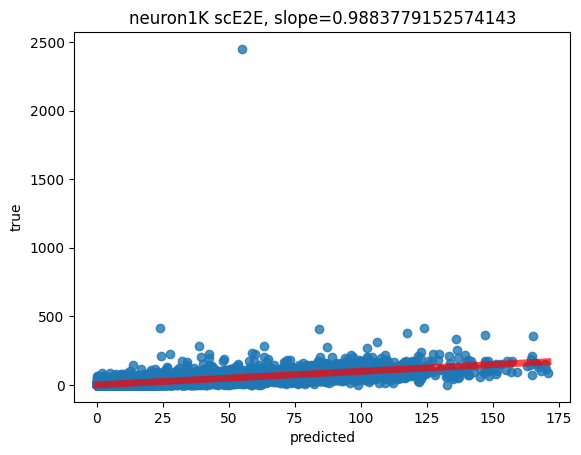

In [709]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

p=sns.regplot(x=dropout_pred.cpu().numpy().reshape(-1,), y=np.asarray(dropout_true).reshape(-1,), line_kws={"color":"r","alpha":0.7,"lw":5})
#calculate slope and intercept of regression equation

slope, intercept, r, p, sterr = scipy.stats.linregress(x=p.get_lines()[0].get_xdata(),
                                                       y=p.get_lines()[0].get_ydata())
plt.title('neuron1K scE2E, slope={}'.format(slope))
plt.xlabel('predicted')
plt.ylabel('true')
plt.savefig('neuron1k_correlation.pdf')

In [ ]:
dropout_pred.cpu().numpy().reshape(-1,)

In [ ]:
#### 

#### Clustering original data

In [1012]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from anndata import AnnData

In [1013]:
adata_ori=AnnData(adata.raw.X.A)

In [1014]:
adata_tmp=AnnData.copy(adata)

In [1015]:
adata_ori.obs['cluster'] = adata_tmp.obs['cluster'].values
adata_ori.obs['cluster'] = adata_ori.obs['cluster'].map({'d0': 0, 'd2': 1, 'd4': 2, 'd7': 3})

In [1016]:
adata_ori.obs

,cluster
0,0
1,0
2,0
3,0
4,0
...,...
2708,3
2709,3
2710,3
2711,3


In [1017]:
if np.isinf(adata_ori.X).any() or np.isnan(adata_ori.X).any():
    print("Infinities or NaNs found in the data.")
else:
    print("No infinities or NaNs found in the data.")

finite_max_value = np.nanmax(adata_ori.X[np.isfinite(adata_ori.X)])
adata_ori.X[np.isinf(adata_ori.X)] = finite_max_value / 2

No infinities or NaNs found in the data.


In [1018]:
sc.pp.normalize_total(adata_ori)
sc.pp.log1p(adata_ori)
sc.pp.highly_variable_genes(adata_ori, n_top_genes=2000)
adata_ori = adata_ori[:, adata_ori.var.highly_variable]
print(adata_ori.X.shape)
sc.pp.scale(adata_ori, max_value=10)

(2713, 2000)


D:\Anaconda3\envs\pytorch\lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [1019]:
# 降维
sc.tl.pca(adata_ori, svd_solver='arpack')
sc.pp.neighbors(adata_ori, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata_ori)

D:\Anaconda3\envs\pytorch\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


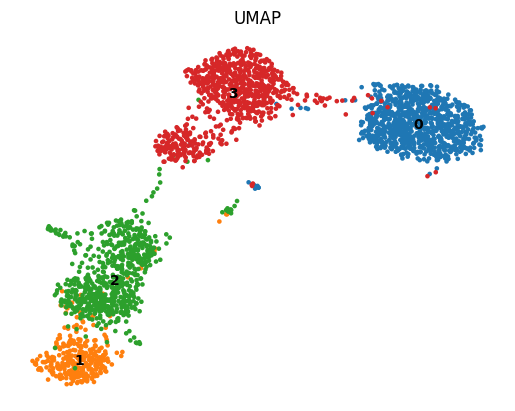

In [1020]:
sc.pl.umap(adata_ori, color=['cluster'], legend_loc='on data', title='UMAP', frameon=False)

In [1021]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# K-means聚类
kmeans = KMeans(n_clusters=4, random_state=0)
adata_ori.obs['kmeans_clusters'] = kmeans.fit_predict(adata_ori.X)

ground_truth = adata_ori.obs['cluster'].tolist()
cluster_results = adata_ori.obs['kmeans_clusters'].tolist()

ari = adjusted_rand_score(ground_truth, cluster_results)
nmi = normalized_mutual_info_score(ground_truth, cluster_results)

print("ARI: ", ari)
print("NMI: ", nmi)

cluster_labels = kmeans.fit_predict(adata_ori.X)

from sklearn.metrics import silhouette_score

# 计算轮廓系数
sil_score = silhouette_score(adata_ori.obsm['X_umap'], cluster_labels)

print("Silhouette Score: ", sil_score)

ARI:  0.7450175558914807
NMI:  0.7496041780593611
Silhouette Score:  0.5106855


#### Clustering imputed data

In [1168]:
import copy
X_imputed_all=copy.deepcopy(result.cpu().numpy())

In [1169]:
X_imputed_all

array([[0.32318515, 0.42147014, 0.29094416, ..., 0.06103837, 1.4406474 ,
        0.01032803],
       [0.29171   , 0.6515649 , 0.3834957 , ..., 0.05700302, 1.7027984 ,
        0.00411961],
       [0.26847374, 0.64170337, 0.4034596 , ..., 0.05527333, 1.7087336 ,
        0.00525923],
       ...,
       [0.24610774, 0.5899048 , 0.38723907, ..., 0.03414851, 1.3851713 ,
        0.        ],
       [0.23794058, 0.6277144 , 0.42060402, ..., 0.05423737, 1.3859863 ,
        0.        ],
       [0.21080431, 0.53550535, 0.3556883 , ..., 0.0514858 , 1.1498626 ,
        0.        ]], dtype=float32)

In [1170]:
import anndata
adata_imp_all=anndata.AnnData(X=X_imputed_all)

In [1171]:
adata.obs

,cluster,n_genes_by_counts,total_counts,n_genes
0-d0,d0,14195,39366.0,14195
1-d0,d0,15330,44271.0,15330
2-d0,d0,15055,46656.0,15055
3-d0,d0,12729,30461.0,12729
4-d0,d0,7455,13396.0,7455
...,...,...,...,...
793-d7,d7,12538,31558.0,12538
794-d7,d7,16431,53669.0,16431
795-d7,d7,12634,30256.0,12634
796-d7,d7,16333,48644.0,16333


In [1172]:
adata_imp_all.obs['cluster']=adata.obs['cluster'].values #.map({'d0': 0, 'd2': 1, 'd4': 2, 'd7': 3})

In [1173]:
adata_imp_all.obs['cluster']=adata_imp_all.obs['cluster'].map({'d0': 0, 'd2': 1, 'd4': 2, 'd7': 3})

In [1174]:
adata_imp_all.obs

,cluster
0,0
1,0
2,0
3,0
4,0
...,...
2708,3
2709,3
2710,3
2711,3


In [1175]:
sc.pp.normalize_total(adata_imp_all)
sc.pp.log1p(adata_imp_all)
sc.pp.highly_variable_genes(adata_imp_all, n_top_genes=2000)
adata_imp_all = adata_imp_all[:, adata_imp_all.var.highly_variable]
sc.pp.scale(adata_imp_all, max_value=10)

D:\Anaconda3\envs\pytorch\lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [1176]:
# 降维
sc.tl.pca(adata_imp_all, svd_solver='arpack')
sc.pp.neighbors(adata_imp_all, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata_imp_all)

D:\Anaconda3\envs\pytorch\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


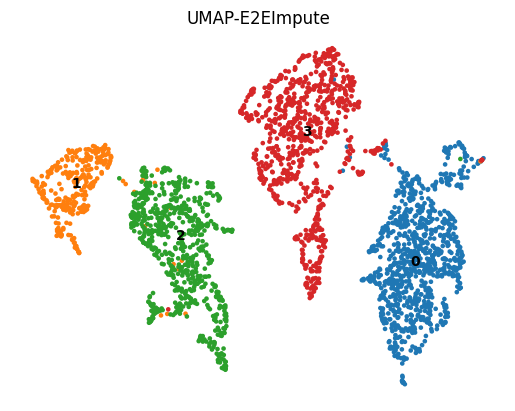

In [1177]:
sc.pl.umap(adata_imp_all, color=['cluster'], legend_loc='on data', title='UMAP-E2EImpute', frameon=False)

In [1178]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# K-means聚类
kmeans = KMeans(n_clusters=4).fit(adata_imp_all.X)


ground_truth = adata_imp_all.obs.cluster.values
#cluster_results = adata_imp_all.obs['kmeans_clusters'].tolist()

ari = adjusted_rand_score(ground_truth, kmeans.labels_)
nmi = normalized_mutual_info_score(ground_truth, kmeans.labels_)

from sklearn.metrics import silhouette_score
# 计算轮廓系数
sil_score = silhouette_score(adata_imp_all.obsm['X_umap'],kmeans.labels_)

print("ARI: ", ari)
print("NMI: ", nmi)
print("Silhouette Score: ", sil_score)

ARI:  0.9547311664742741
NMI:  0.9275137393471826
Silhouette Score:  0.54366094


In [1130]:
ground_truth

[0, 0, 0, 0, 0, ..., 3, 3, 3, 3, 3]
Length: 2713
Categories (4, int64): [0, 1, 2, 3]

In [ ]:
adata_imp_all.obs